# Spectrograms - CNN Test

In [28]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam

import sqlalchemy
from sqlalchemy import create_engine, inspect

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from pprint import pprint

import os
import sys
import time
from datetime import datetime
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from joblib import dump

%run functions.ipynb

In [2]:
# Time the run
start_time = time.time()

## Import datasets

In [3]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['alexaval',
 'alexbval',
 'alexgval',
 'alexrval',
 'aval',
 'bval',
 'chroma1',
 'chroma10',
 'chroma11',
 'chroma12',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chromastd',
 'deltachroma1',
 'deltachroma10',
 'deltachroma11',
 'deltachroma12',
 'deltachroma2',
 'deltachroma3',
 'deltachroma4',
 'deltachroma5',
 'deltachroma6',
 'deltachroma7',
 'deltachroma8',
 'deltachroma9',
 'deltachromastd',
 'deltaenergy',
 'deltaenergyentropy',
 'deltamfcc1',
 'deltamfcc10',
 'deltamfcc11',
 'deltamfcc12',
 'deltamfcc13',
 'deltamfcc2',
 'deltamfcc3',
 'deltamfcc4',
 'deltamfcc5',
 'deltamfcc6',
 'deltamfcc7',
 'deltamfcc8',
 'deltamfcc9',
 'deltaspectralcentroid',
 'deltaspectralentropy',
 'deltaspectralflux',
 'deltaspectralrolloff',
 'deltaspectralspread',
 'deltazcr',
 'demographic',
 'diagnosis',
 'energy',
 'energyentropy',
 'gval',
 'habits',
 'mfcc1',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5

In [4]:
# Tables to import
import_tables = ['diagnosis', 'rval', 'gval', 'bval', 'aval']

In [5]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in import_tables:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

## Preprocessing

### Define the target variable

In [6]:
# Sort the diagnosis dataframe
dataframes['diagnosis_df'] = dataframes['diagnosis_df'].sort_values(by='id').reset_index(drop=True)

# Isolate the diagnosis column
y = dataframes['diagnosis_df']['diagnosis'].copy()

# Encode the target variable, ignore subtype
y = y.apply(encode_binary)
y

0      1
1      0
2      1
3      1
4      1
      ..
199    0
200    1
201    0
202    0
203    1
Name: diagnosis, Length: 204, dtype: int64

In [7]:
# Check the aval_df
dataframes['aval_df'].describe()

voice156  voice142  voice195  voice181  voice022  voice036  voice208  \
count   37350.0   37350.0   37350.0   37350.0   37350.0   37350.0   37350.0   
mean      255.0     255.0     255.0     255.0     255.0     255.0     255.0   
std         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
min       255.0     255.0     255.0     255.0     255.0     255.0     255.0   
25%       255.0     255.0     255.0     255.0     255.0     255.0     255.0   
50%       255.0     255.0     255.0     255.0     255.0     255.0     255.0   
75%       255.0     255.0     255.0     255.0     255.0     255.0     255.0   
max       255.0     255.0     255.0     255.0     255.0     255.0     255.0   

       voice037  voice023  voice180  ...  voice166  voice199  voice012  \
count   37350.0   37350.0   37350.0  ...   37350.0   37350.0   37350.0   
mean      255.0     255.0     255.0  ...     255.0     255.0     255.0   
std         0.0       0.0       0.0  ...       0.0       0.0       0.0   
min       255.0     255.0     255.0  ...     255.0     255.0     255.0   
25%       255.0     255.0     255.0  ...     255.0     255.0     255.0   
50%       255.0     255.0     255.0  ...     255.0     255.0     255.0   
75%       255.0     255.0     255.0  ...     255.0     255.0     255.0   
max       255.0     255.0     255.0  ...     255.0     255.0     255.0   

       voice204  voice205  voice013  voice007  voice198  voice167  voice173  
count   37350.0   37350.0   37350.0   37350.0   37350.0   37350.0   37350.0  
mean      255.0     255.0     255.0     255.0     255.0     255.0     255.0  
std         0.0       0.0       0.0       0.0       0.0       0.0       0.0  
min       255.0     255.0     255.0     255.0     255.0     255.0     255.0  
25%       255.0     255.0     255.0     255.0     255.0     255.0     255.0  
50%       255.0     255.0     255.0     255.0     255.0     255.0     255.0  
75%       255.0     255.0     255.0     255.0     255.0     255.0     255.0  
max       255.0     255.0     255.0     255.0     255.0     255.0     255.0  

[8 rows x 204 columns]

__NOTE__: The A-channel is all the same, might not be adding value.

### Reshape the feature variables

In [8]:
# Input shape
width_px = 225
height_px = 166

num_channels = 3 # since RGB

# Define inputs
input_shape = (height_px, width_px, num_channels)
input_reshape = (height_px, width_px)

voice001  voice002  voice003  voice004  voice007  voice008  voice009  \
0            47        47        47        47        47        47        47   
1            47        47        47        47        47        47        47   
2            43        43        43        43        43        43        43   
3            20        20        19        21        20        20        20   
4            19        19        18        20        20        20        19   
...         ...       ...       ...       ...       ...       ...       ...   
37345       199       200       200       200       199       200       200   
37346       225       226       226       226       225       226       226   
37347       225       225       225       225       224       225       226   
37348       247       247       246       247       247       247       246   
37349       250       250       250       250       250       250       250   

       voice010  voice011  voice012  ...  voice199  voice200  voice201  \
0            47        47        47  ...        47        47        47   
1            47        47        47  ...        47        47        47   
2            43        43        44  ...        43        43        45   
3            20        20        25  ...        24        24        41   
4            19        19        24  ...        24        23        41   
...         ...       ...       ...  ...       ...       ...       ...   
37345       199       200       162  ...       160       200       199   
37346       225       226       162  ...       160       226       225   
37347       225       225       165  ...       163       225       225   
37348       247       246       237  ...       237       247       247   
37349       250       250       248  ...       248       250       250   

       voice202  voice203  voice204  voice205  voice206  voice207  voice208  
0            47        47        47        47        47        47        47  
1            47        47        47        47        47        47        47  
2            43        43        43        43        43        43        43  
3            22        20        20        21        20        20        19  
4            21        20        19        20        19        19        19  
...         ...       ...       ...       ...       ...       ...       ...  
37345       200       199       200       200       200       199       200  
37346       226       225       226       226       226       225       226  
37347       225       225       225       225       225       225       225  
37348       247       246       247       247       247       247       246  
37349       250       250       250       250       250       250       250  

[37350 rows x 204 columns]

voice001  voice002  voice003  voice004  voice007  voice008  voice009  \
0            17        17        17        17        17        17        17   
1            17        17        17        17        17        17        17   
2            16        16        16        16        16        16        16   
3            13        13        13        13        13        14        13   
4            13        13        13        13        13        14        13   
...         ...       ...       ...       ...       ...       ...       ...   
37345       119       119       119       120       118       119       119   
37346       127       127       127       128       127       127       128   
37347       128       128       128       128       127       128       128   
37348       156       156       157       157       156       157       157   
37349       161       161       162       162       161       162       162   

       voice010  voice011  voice012  ...  voice199  voice200  voice201  \
0            17        17        17  ...        17        17        17   
1            17        17        17  ...        17        17        17   
2            16        16        16  ...        16        16        16   
3            13        14        15  ...        14        14        16   
4            13        14        15  ...        14        14        16   
...         ...       ...       ...  ...       ...       ...       ...   
37345       119       119       103  ...       102       119       119   
37346       127       127       103  ...       102       127       127   
37347       128       128       104  ...       104       128       128   
37348       156       157       150  ...       150       157       156   
37349       161       162       157  ...       157       162       161   

       voice202  voice203  voice204  voice205  voice206  voice207  voice208  
0            17        17        17        17        17        17        17  
1            17        17        17        17        17        17        17  
2            16        16        16        16        16        16        16  
3            14        14        12        13        14        13        13  
4            13        14        12        13        14        13        13  
...         ...       ...       ...       ...       ...       ...       ...  
37345       119       119       119       119       119       119       119  
37346       127       127       127       127       127       127       128  
37347       128       127       128       128       128       128       128  
37348       157       157       157       157       157       156       157  
37349       162       162       162       162       162       161       162  

[37350 rows x 204 columns]

voice001  voice002  voice003  voice004  voice007  voice008  voice009  \
0            99        99        99        99        99        99        99   
1            99        99        99        99        99        99        99   
2            93        93        92        93        92        93        93   
3            53        54        51        56        55        54        53   
4            52        53        50        55        53        53        52   
...         ...       ...       ...       ...       ...       ...       ...   
37345       117       117       117       117       118       117       117   
37346       131       131       131       131       132       131       131   
37347       130       130       130       130       131       130       130   
37348       121       121       121       121       121       121       121   
37349       120       120       120       120       120       120       120   

       voice010  voice011  voice012  ...  voice199  voice200  voice201  \
0            99        99        99  ...        99        99        99   
1            99        99        99  ...        99        99        99   
2            93        93        94  ...        93        93        97   
3            54        53        64  ...        62        61        88   
4            52        52        62  ...        61        60        87   
...         ...       ...       ...  ...       ...       ...       ...   
37345       117       117       138  ...       138       117       117   
37346       131       131       139  ...       138       131       131   
37347       130       130       138  ...       138       130       130   
37348       121       121       123  ...       123       121       121   
37349       120       120       120  ...       120       120       120   

       voice202  voice203  voice204  voice205  voice206  voice207  voice208  
0            99        99        99        99        99        99        99  
1            99        99        99        99        99        99        99  
2            93        93        92        93        93        92        92  
3            58        55        53        56        54        52        52  
4            56        54        52        54        53        51        51  
...         ...       ...       ...       ...       ...       ...       ...  
37345       117       117       117       117       117       117       117  
37346       131       131       131       131       131       131       131  
37347       130       130       130       130       130       130       130  
37348       121       121       121       121       121       121       121  
37349       120       120       120       120       120       120       120  

[37350 rows x 204 columns]

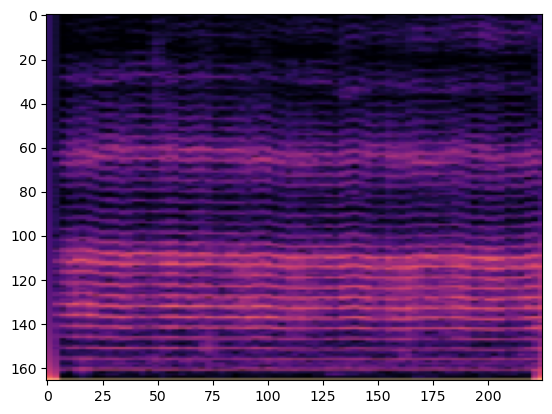

In [9]:
# Dataframe order
rgb_order = ['rval_df', 'gval_df', 'bval_df']

# Initialise list to hold the dataframes
rgba_df_list = []

# Loop through all the dataframes
for df in rgb_order:
    
    # Sort the columns
    dataframes[df] = dataframes[df].sort_index(axis=1)
    display(dataframes[df])
    
    # Define the df columns
    df_cols = dataframes[df].columns

    # Reshape to its original dimensions
    data = np.array(
        [dataframes[df][col].values.reshape(input_reshape) for col in df_cols]
    )

    # Append to the list
    rgba_df_list.append(data)

# Define the feature variables
X = np.stack(rgba_df_list, axis=-1)

# Display the first for confirmation
plt.imshow(X[0])
plt.show()

### Split and Scale

In [10]:
# Split the preprocessed data to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [11]:
# Reshape the data
X_train_reshaped = X_train.reshape((
    X_train.shape[0], # total number of samples
    height_px * width_px * num_channels # total number flattened
))

X_test_reshaped = X_test.reshape((
    X_test.shape[0],
    height_px * width_px * num_channels
))

In [32]:
X_train.shape[0]

153

In [12]:
# Normalize training data to be between 0 and 1
X_scaler = MinMaxScaler()

# Scale the data
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.fit_transform(X_test_reshaped)

# Reshape the data back to the original
X_train_scaled = X_train_scaled.reshape((
    X_train_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

X_test_scaled = X_test_scaled.reshape((
    X_test_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

In [29]:
# Save the scaler
dump(X_scaler, '../voice_app/assets/cnn_scaler.joblib')

['../voice_app/assets/cnn_scaler.joblib']

## Initial Test Model

__GUIDELINES__

- The number of filters for convolutional layers should:
    - Be a value to the power of 2
    - Increase for each following layer (i.e. `32`, `64`, `128`)
- The number of neurons for the fully connected layers should:
    - Be a value to the power of 2
    - Decrease for each following layer (i.e. `64`, `32`)
- Kernel size must be an odd integer

In [13]:
# Define the CNN model
cnn = Sequential()

# Define the pool size
pool_size = (2, 2)

# Add the first convolutional layer
cnn.add(Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation = 'relu',
    input_shape = (height_px, width_px, num_channels)
))
cnn.add(MaxPooling2D(pool_size))

# Add the second convolutional layer
cnn.add(Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation = 'relu'
))
cnn.add(MaxPooling2D(pool_size))

# Add the third convolutional layer
cnn.add(Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation = 'relu'
))
cnn.add(MaxPooling2D(pool_size))

# Add the fourth convolutional layer
cnn.add(Conv2D(
    filters = 256,
    kernel_size = (3, 3),
    activation = 'relu'
))
cnn.add(MaxPooling2D(pool_size))

# Flatten the output before feeding to the fully connected layers
cnn.add(Flatten())

# Add dense layers for classification
cnn.add(Dense(
    units = 256,
    activation = 'relu'
))

cnn.add(Dense(
    units = 64,
    activation = 'relu'
))

# Add the output layer
cnn.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

# Display the summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 164, 223, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 82, 111, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 109, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 26, 128)       0

In [14]:
# Compile the model
cnn.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [15]:
# Train the model
fit_model = cnn.fit(
    X_train_scaled,
    y_train,
    epochs = 15,
    shuffle = True, # reduce risk of overfitting
    verbose = 1
)

Epoch 1/15
5/5 [==============================] - 2s 292ms/step - loss: 0.7001 - accuracy: 0.5359
Epoch 2/15
5/5 [==============================] - 1s 291ms/step - loss: 0.5974 - accuracy: 0.7190
Epoch 3/15
5/5 [==============================] - 1s 294ms/step - loss: 0.6165 - accuracy: 0.7190
Epoch 4/15
5/5 [==============================] - 2s 301ms/step - loss: 0.6049 - accuracy: 0.7190
Epoch 5/15
5/5 [==============================] - 1s 289ms/step - loss: 0.5943 - accuracy: 0.7190
Epoch 6/15
5/5 [==============================] - 2s 297ms/step - loss: 0.6099 - accuracy: 0.7190
Epoch 7/15
5/5 [==============================] - 1s 295ms/step - loss: 0.5828 - accuracy: 0.7190
Epoch 8/15
5/5 [==============================] - 2s 306ms/step - loss: 0.5702 - accuracy: 0.7190
Epoch 9/15
5/5 [==============================] - 1s 286ms/step - loss: 0.5635 - accuracy: 0.7451
Epoch 10/15
5/5 [==============================] - 1s 283ms/step - loss: 0.5603 - accuracy: 0.7516
Epoch 11/15
5/5 [==

In [16]:
# Evaluate the model using the test data
model_loss, model_accuracy = cnn.evaluate(
    X_test_scaled,
    y_test,
    verbose = 2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.6753 - accuracy: 0.7451 - 190ms/epoch - 95ms/step
Loss: 0.6753267645835876, Accuracy: 0.7450980544090271


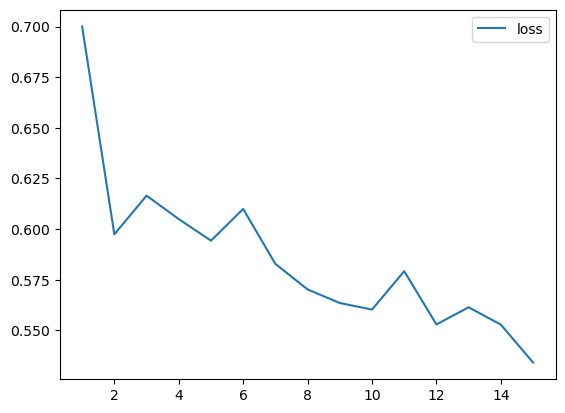

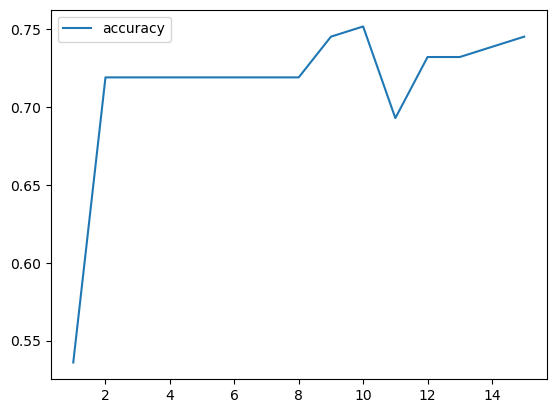

In [17]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

## Save Results to Performance Tracker

In [18]:
# Create dictionary to save the results
results_dict = dict()

current_time = datetime.now()
results_dict['timestamp'] = current_time
results_dict['runtime'] = time.time() - start_time
results_dict['model_loss'] = model_loss
results_dict['model_accuracy'] = model_accuracy

In [19]:
# Change message
change_message = input("Changes from previous iteration: ")

# Append to results_dict
results_dict['change_message'] = change_message

Changes from previous iteration:  no changes


In [20]:
# Display the dictionary
results_dict

{'timestamp': datetime.datetime(2024, 1, 9, 13, 7, 35, 206338),
 'runtime': 29.367637157440186,
 'model_loss': 0.6753267645835876,
 'model_accuracy': 0.7450980544090271,
 'change_message': 'no changes'}

In [21]:
# Model summary folder path
summary_path = '../resources/tracker/cnn_summary/'
num_files = len(os.listdir(summary_path))

# Export summary to text file
with open(f'{summary_path}cnn_summary_{num_files}.txt', 'w') as f:
    with redirect_stdout(f):
        cnn.summary()
        pprint(results_dict)

In [22]:
# Convert the dictionary to a dataframe
results_df = pd.DataFrame(results_dict, index=[0])
results_df.head()

timestamp    runtime  model_loss  model_accuracy  \
0 2024-01-09 13:07:35.206338  29.367637    0.675327        0.745098   

  change_message  
0     no changes

In [23]:
# Performance tracker
tracker_path = "../resources/tracker/cnn_performance_tracker.csv"

# Model percentage
model_pct = round(model_accuracy, 3)

# Check if the CSV exists
if os.path.exists(tracker_path):
    
    # Read the existing CSV
    tracker_df = pd.read_csv(tracker_path)
    
    # Append the new row of data
    updated_df = pd.concat([tracker_df, results_df], ignore_index=True)
    
    # Update the CSV file
    updated_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_{len(tracker_df)}_{model_pct}.h5', save_format='h5')

else:    
    # Export to CSV
    results_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_0_{model_pct}.h5', save_format='h5')

/Users/alyssahondrade/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Understand the Predictions

In [24]:
# Check the prediction's output probabilities
predicted_prob = cnn.predict(X_test_scaled)
clean_prob = np.round(predicted_prob, 2)

# Round to the nearest integer and flatten
clean_predicted = np.round(predicted_prob).astype(int).flatten()

# Convert to a dataframe for readability
output_prob = pd.DataFrame({
    'Actual': y_test,
    'Predicted': clean_predicted,
    'Probability': clean_prob.flatten()
})
output_prob

2/2 [==============================] - 0s 53ms/step


Actual  Predicted  Probability
66        1          1         0.83
56        0          1         0.82
112       1          1         1.00
8         1          1         0.80
194       1          1         1.00
111       1          1         1.00
118       0          1         0.87
86        0          0         0.50
0         1          1         0.75
141       1          1         0.86
71        1          1         0.74
201       0          1         0.92
196       1          1         0.98
174       0          1         0.75
139       1          1         0.84
88        1          1         0.87
119       1          1         1.00
100       1          1         0.86
6         1          1         0.84
93        0          1         0.88
54        1          1         0.76
81        1          1         0.85
78        1          1         0.78
48        0          1         0.84
27        1          1         0.85
53        1          1         0.84
29        0          1         0.79
159       1          1         0.84
170       1          1         0.83
178       0          1         0.78
199       0          1         1.00
132       1          1         0.68
4         1          1         0.88
182       1          1         0.88
121       1          1         0.63
50        1          1         0.81
135       1          1         0.85
9         1          1         0.86
131       1          1         0.87
165       1          1         0.86
148       1          1         0.84
126       1          1         0.84
24        1          1         0.73
152       1          0         0.44
129       0          0         0.38
151       1          1         0.84
134       0          1         0.80
110       0          1         0.85
166       1          1         0.87
63        1          1         0.77
80        0          1         0.79

In [25]:
# Identify incorrect predictions
output_prob.loc[output_prob['Actual'] != output_prob['Predicted']]

Actual  Predicted  Probability
56        0          1         0.82
118       0          1         0.87
201       0          1         0.92
174       0          1         0.75
93        0          1         0.88
48        0          1         0.84
29        0          1         0.79
178       0          1         0.78
199       0          1         1.00
152       1          0         0.44
134       0          1         0.80
110       0          1         0.85
80        0          1         0.79

In [26]:
# Display incorrect indices
incorrect_idx = output_prob.loc[output_prob['Actual'] != output_prob['Predicted']].index
incorrect_idx

Index([56, 118, 201, 174, 93, 48, 29, 178, 199, 152, 134, 110, 80], dtype='int64')

In [27]:
# Display incorrect predictions as a complete dataframe
dataframes['diagnosis_df'].iloc[incorrect_idx]

id               diagnosis     subtype  vhi_score  rsi_score  \
56   voice061                 healthy  no subtype         19         12   
118  voice123                 healthy  no subtype          0          3   
201  voice206                 healthy  no subtype          0          6   
174  voice179                 healthy  no subtype          0         14   
93   voice098                 healthy  no subtype         13         18   
48   voice051                 healthy  no subtype          2         13   
29   voice032                 healthy  no subtype         16         18   
178  voice183                 healthy  no subtype          0          6   
199  voice204                 healthy  no subtype          0          7   
152  voice157  hyperkinetic dysphonia    prolapse         31          0   
134  voice139                 healthy  no subtype         22         11   
110  voice115                 healthy  no subtype         26         14   
80   voice085                 healthy  no subtype         11          4   

     reflux_indicated  vhi_zscore  vhi_impact  
56                  0        0.68           1  
118                 0       -0.58           0  
201                 0       -0.58           0  
174                 1       -0.58           0  
93                  1        0.28           1  
48                  1       -0.45           0  
29                  1        0.48           1  
178                 0       -0.58           0  
199                 0       -0.58           0  
152                 0        1.49           2  
134                 0        0.89           1  
110                 1        1.15           2  
80                  0        0.15           1